<a href="https://colab.research.google.com/github/AnujKrishnaPhuyal/NLP/blob/main/Sentiment_ananlysis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
!pip install -qq google-play-scraper

NECESSARY IMPORTS FOR OUR MODEL

In [168]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm
import json
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

TESTING FEW IMPORTS

In [169]:
# Sample JSON code
json_code = '{"name": "John", "age": 30, "city": "New York"}'

# Apply syntax highlighting to the JSON code using JsonLexer and TerminalFormatter
highlighted_code = highlight(json_code, JsonLexer(), TerminalFormatter())

# Print the highlighted code
print(highlighted_code)


{"name": "John", "age": 30, "city": "New York"}



SETTING UP THE REQUIRED ID'S OF DOMAINS FOR SCRAPPING OF REVIEWS AND OTHER DATAS


In [170]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]


LOOPING OVER THE DOMAINS ID

In [171]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 15/15 [00:02<00:00,  5.97it/s]


In [172]:
def print_json_data(json_data):
  json_data = json.dumps(json_data,
    indent=2,
    sort_keys=True,
    default=str )
  print(highlight(json_data, JsonLexer(), TerminalFormatter()))


CHECKING OUR DATAS OBTAINED FROM PREVIOUS STEPS

In [173]:
print_json_data(app_infos[4])

{
  "adSupported": true,
  "appId": "cc.forestapp",
  "categories": [
    {
      "id": "PRODUCTIVITY",
      "name": "Productivity"
    }
  ],
  "containsAds": true,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Can't stop scrolling? Lack of self-control? Forest is the solution that has the cutest focus timer to help you stay focused and boost productivity!\r\n\r\n<b>\u2605 2018 Google Play Editors\u2019 Choice Top Productivity App\u2605</b>\r\n\r\n<b>\u2605 2018 Google Play Best Self-improvement app in 9 countries, including, Canada, France, Japan, Korea and more!\u2605</b>\r\n\r\n<b>\u2605 Google Play 2018 Best Social Impact App Nomination\u2605</b>\r\n\r\n<b>\u2605 Google Play 2015-2016 Best App of the Year\u2605</b>\r\n\r\nPlant a seed in Forest when you need to put down your phone and stay focused to get your to do list done.\r\n\r\nAs you stay focused, this seed will gradually grow into a tree. However, if you cannot re

NOW EXTRACTING APP REVIEWS

In [174]:
app_reviews =[]

for ap in app_packages:
  for score in list(range(1,6)):
      for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
          rvs, _ = reviews(
                            ap,
                            lang='en',
                            country='us',
                            sort=sort_order,
                            count= 200 if score == 3 else 100,
                            filter_score_with=score
                          )
          for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap
          app_reviews.extend(rvs)




In [175]:
print_json_data(app_reviews[3])

{
  "appId": "com.anydo",
  "appVersion": null,
  "at": "2020-11-16 01:50:16",
  "content": "Terrible Update! This app used to be perfect for planning out when certain tasks were to be completed. The interface was easy to understand and you could see and plan as many days into the future as you wanted, and everything was perfectly broken down by date. Now when you add tasks, regardless of when they need to be completed, the app just says to do it today. It has completely eliminated the only use for this app, which was to make out a planned future.",
  "repliedAt": "2020-11-17 09:31:35",
  "replyContent": "Please note that the tasks in your tasks view are sorted by their reminder date, to move a task to Tomorrow/ Upcoming/ Someday, simply add the relevant reminder. That said, we are unaware of any issues with tasks being set to Today, so that's odd. Please send us a bug report via your app Settings - Support, so we can look into this for you.",
  "reviewCreatedVersion": null,
  "reviewI

In [176]:
apps_rv= pd.DataFrame(app_reviews)
apps_rv.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,0197c118-5c6f-4a7b-894c-970023d1a350,Mar Zur,https://play-lh.googleusercontent.com/a/ACg8oc...,I have the same recurring tasks to do every da...,1,10,4.16.6.2,2020-07-22 13:13:10,Our team will be happy to look into it for you...,2020-07-23 16:32:02,4.16.6.2,most_relevant,com.anydo
1,94868fb5-a21d-4ef9-ab85-81b2ed3d0785,Devin Rivera,https://play-lh.googleusercontent.com/a-/ALV-U...,"Instead of shopping around, I downloaded Any.d...",1,7,None,2020-12-08 06:24:40,We are not aware of any issues with randomized...,2020-12-10 09:38:20,None,most_relevant,com.anydo
2,825da34e-f65d-4ef3-991d-02d5291820d6,Heidi Kinsley,https://play-lh.googleusercontent.com/a/ACg8oc...,Why does every once in a while... out of the b...,1,6,5.11.1.2,2021-07-09 13:51:56,Sorry to hear that! It sounds like you might h...,2021-07-11 11:16:55,5.11.1.2,most_relevant,com.anydo
3,a49c2875-651a-4c33-b79c-5813780d659e,Daniel Keller,https://play-lh.googleusercontent.com/a/ACg8oc...,Terrible Update! This app used to be perfect f...,1,6,None,2020-11-16 01:50:16,Please note that the tasks in your tasks view ...,2020-11-17 09:31:35,None,most_relevant,com.anydo
4,9482c75e-2e63-46ab-8c94-47273dd6a829,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app is deceivingly terrible. There are so...,1,20,4.14.0.4,2019-01-31 16:19:40,"Hi Ryan, it sounds like you are describing our...",2019-02-05 11:52:44,4.14.0.4,most_relevant,com.anydo


#DOWNLOADING THE OBTAINED DATS'S INTO CSV FILES THAT WILL BE EASIER FOR FURTHER STEPS

In [177]:
apps_rv.to_csv('review.csv', index = None, header = True)

In [178]:
df = pd.read_csv('review.csv')
df.shape

(17636, 13)

In [179]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,0197c118-5c6f-4a7b-894c-970023d1a350,Mar Zur,https://play-lh.googleusercontent.com/a/ACg8oc...,I have the same recurring tasks to do every da...,1,10,4.16.6.2,2020-07-22 13:13:10,Our team will be happy to look into it for you...,2020-07-23 16:32:02,4.16.6.2,most_relevant,com.anydo
1,94868fb5-a21d-4ef9-ab85-81b2ed3d0785,Devin Rivera,https://play-lh.googleusercontent.com/a-/ALV-U...,"Instead of shopping around, I downloaded Any.d...",1,7,NaN,2020-12-08 06:24:40,We are not aware of any issues with randomized...,2020-12-10 09:38:20,NaN,most_relevant,com.anydo
2,825da34e-f65d-4ef3-991d-02d5291820d6,Heidi Kinsley,https://play-lh.googleusercontent.com/a/ACg8oc...,Why does every once in a while... out of the b...,1,6,5.11.1.2,2021-07-09 13:51:56,Sorry to hear that! It sounds like you might h...,2021-07-11 11:16:55,5.11.1.2,most_relevant,com.anydo
3,a49c2875-651a-4c33-b79c-5813780d659e,Daniel Keller,https://play-lh.googleusercontent.com/a/ACg8oc...,Terrible Update! This app used to be perfect f...,1,6,NaN,2020-11-16 01:50:16,Please note that the tasks in your tasks view ...,2020-11-17 09:31:35,NaN,most_relevant,com.anydo
4,9482c75e-2e63-46ab-8c94-47273dd6a829,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app is deceivingly terrible. There are so...,1,20,4.14.0.4,2019-01-31 16:19:40,"Hi Ryan, it sounds like you are describing our...",2019-02-05 11:52:44,4.14.0.4,most_relevant,com.anydo


<Axes: xlabel='score', ylabel='count'>

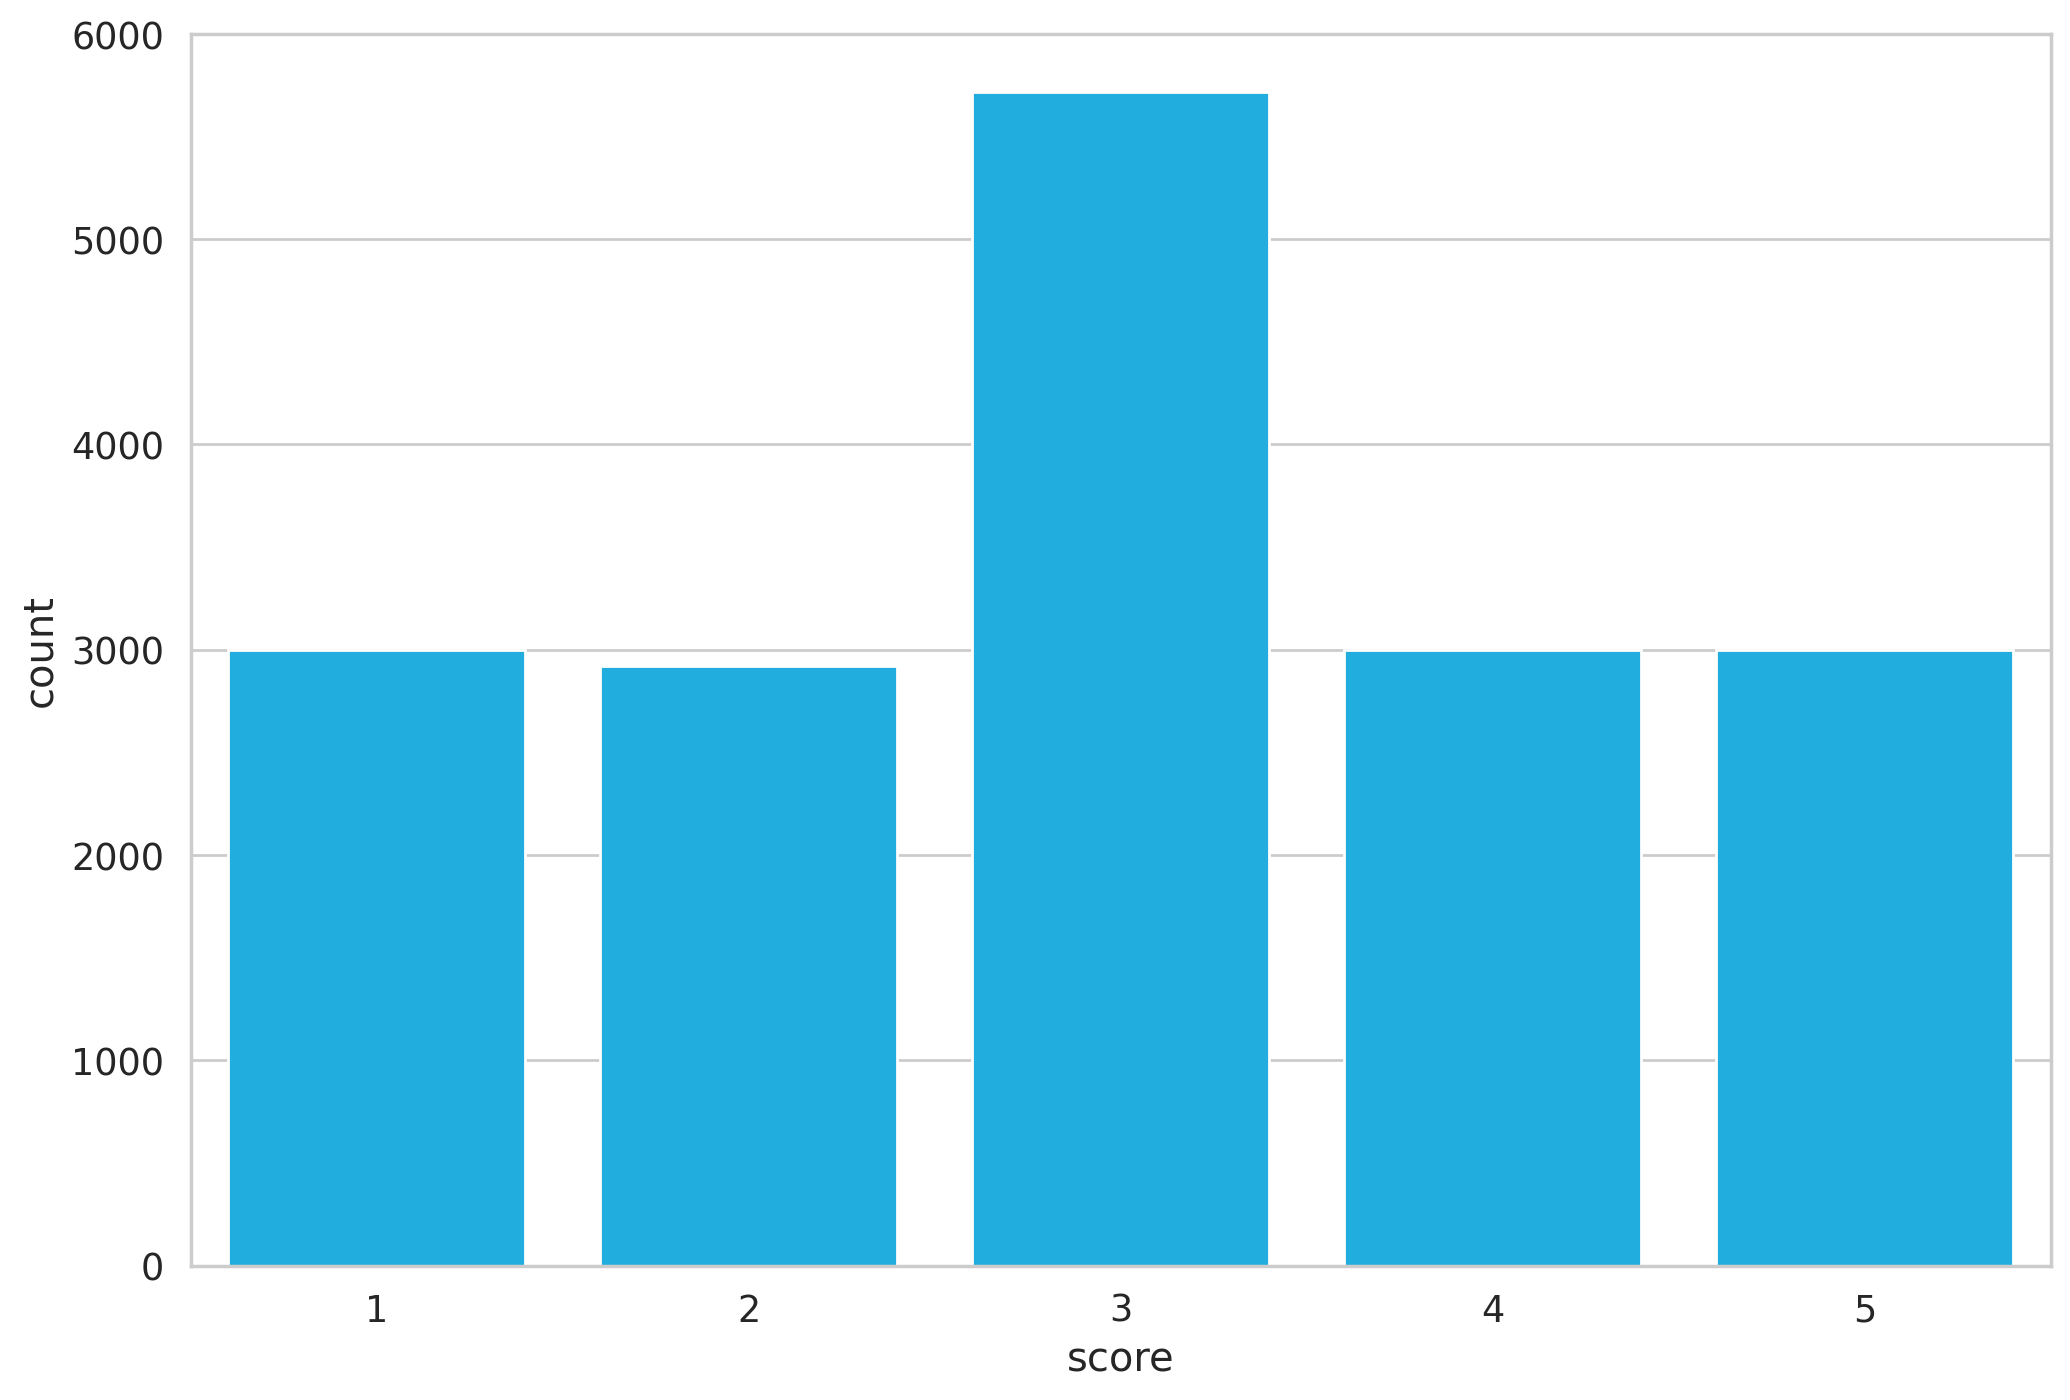

In [180]:
sns.countplot(x =df['score'], data=df)

CONVERTING APP REVIEWS IN OUR DESIRED FORMAT BASED UPON THE SCORE EACH REVIEWS CONTAINS

In [181]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)


In [182]:
df.sentiment

0        0
1        0
2        0
3        0
4        0
        ..
17631    2
17632    2
17633    2
17634    2
17635    2
Name: sentiment, Length: 17636, dtype: int64

In [183]:
class_names = ['negative', 'neutral', 'positive']


<ipython-input-184-a4ca0254416a>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


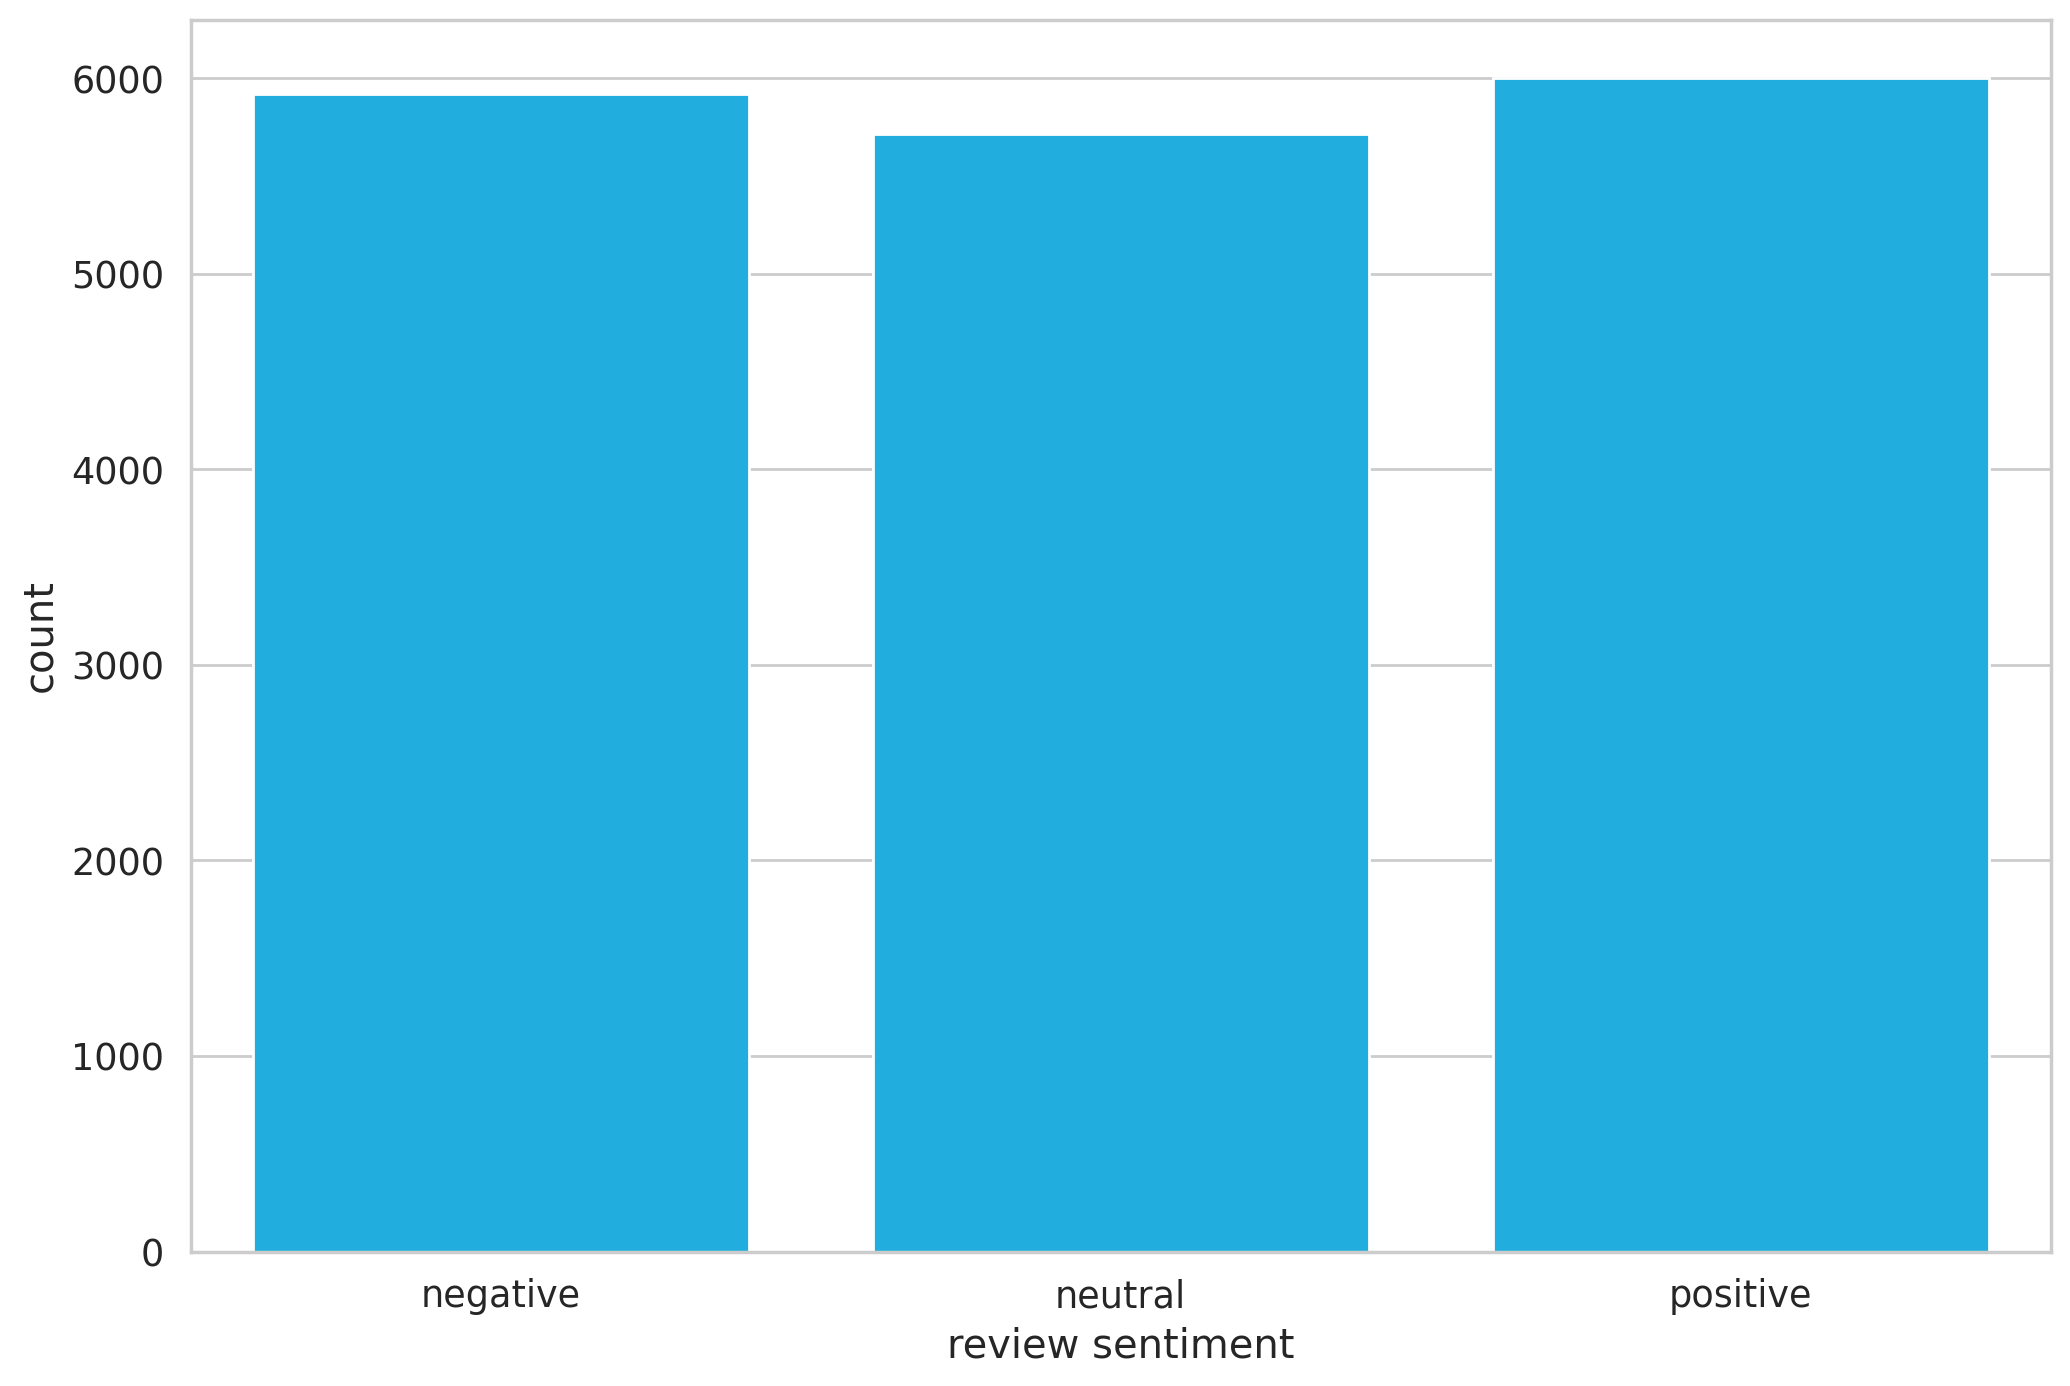

In [184]:
ax = sns.countplot(x = df['sentiment'], data =df)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

#NOW MODEL PREPARATION PHASE

In [185]:
!pip install -qq transformers


In [186]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [187]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


In [188]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


TESTING THE TOKENIZERS AND IT'S IDS FOR BERT MODEL

In [189]:
sampletext= 'he is a player Man? his we have to admit his skills'

In [190]:
tokens = tokenizer.tokenize(sampletext)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sampletext}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: he is a player Man? his we have to admit his skills
   Tokens: ['he', 'is', 'a', 'player', 'Man', '?', 'his', 'we', 'have', 'to', 'admit', 'his', 'skills']
Token IDs: [1119, 1110, 170, 1591, 2268, 136, 1117, 1195, 1138, 1106, 5890, 1117, 4196]


In [191]:
encoding = tokenizer.encode_plus(
  sampletext,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [192]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [193]:
print(len(encoding['input_ids'][0]),encoding['input_ids'], encoding['input_ids'].shape)

32 tensor([[ 101, 1119, 1110,  170, 1591, 2268,  136, 1117, 1195, 1138, 1106, 5890,
         1117, 4196,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]) torch.Size([1, 32])


In [194]:
encoding['attention_mask'].flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Building Datasets, Dataloader and setting Hyperparameters

In [195]:
BATCH_SIZE = 16
MAX_LEN = 160

#Building datasets for subjecting into dataloader


In [196]:

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [197]:
#splitting our datasets
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [198]:
#dataloader function generation

def create_data_loader(df, tokenizer, max_len, batch_size):
   ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
   return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

In [199]:

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [200]:
test_loader = next(iter(train_data_loader))
test_loader.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [201]:
print(test_loader['review_text'][0])
print(test_loader['input_ids'][0])
print(test_loader['attention_mask'][0])
print(test_loader['targets'][0].item())

Been with TickTick for a year, paying for 5 months I think. Mostly love it, but Google Calendar sync is a headache. Expected a smooth sync, but nope! Had to resort to IFTTT for tasks to show up in GCalendar on all my gadgets. Subscribed thinking it'd sync seamlessly, but it's a letdown. Why pay for a half-baked sync? Seriously considering paying IFTTT instead for a smoother experience. TickTick, step up your sync game before we bail for another app that actually set up sync correctly:(
tensor([  101, 18511,  1114,   157,  5345,  1942,  5345,  1111,   170,  1214,
          117,  6573,  1111,   126,  1808,   146,  1341,   119, 21981,  1567,
         1122,   117,  1133,  7986, 26208,   188, 27250,  1110,   170, 16320,
          119, 16409, 26426,  1174,   170,  5307,   188, 27250,   117,  1133,
         1185,  3186,   106,  6467,  1106,  8037,  1106, 13729, 20174,  1942,
         1111,  8249,  1106,  1437,  1146,  1107,   144,  1658,  7531,  7807,
         1197,  1113,  1155,  1139,   176

**Preparing Our Bert Model **

In [202]:
test_loader.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [203]:
test_loader['input_ids'].shape

torch.Size([16, 160])

In [204]:
test_loader['attention_mask'].shape

torch.Size([16, 160])

LOADING OUR MODEL

In [205]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [206]:
outts = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [207]:
pooled_output= outts.pooler_output
pooled_output

tensor([[-0.7692,  0.4052,  0.9999, -0.9947,  0.9551,  0.8259,  0.9858, -0.9724,
         -0.9655, -0.5759,  0.9751,  0.9991, -0.9930, -0.9998,  0.6314, -0.9830,
          0.9912, -0.5930, -1.0000, -0.8070, -0.5430, -0.9999,  0.3486,  0.9546,
          0.9790,  0.0389,  0.9918,  1.0000,  0.8569,  0.0955,  0.3574, -0.9942,
          0.6293, -0.9992,  0.2305,  0.1678,  0.1229, -0.3143,  0.6128, -0.9258,
         -0.5955, -0.6276,  0.5485, -0.5455,  0.6651,  0.2493,  0.1531, -0.0523,
         -0.1233,  0.9999, -0.9570,  0.9998, -0.9874,  0.9984,  0.9957,  0.3217,
          0.9960,  0.1278, -0.9931,  0.3076,  0.9604,  0.0905,  0.8929, -0.1531,
         -0.0396, -0.5129, -0.7335,  0.2049, -0.4403,  0.3204,  0.3438,  0.2906,
          0.9896, -0.9042, -0.0836, -0.9117,  0.3123, -0.9999,  0.9488,  1.0000,
          0.6033, -0.9998,  0.9961, -0.2891, -0.6806,  0.1990, -0.9923, -0.9996,
          0.1785, -0.6183,  0.8900, -0.9890,  0.5229, -0.7637,  1.0000, -0.9178,
         -0.2263,  0.4558,  

In [208]:
type(pooled_output)

torch.Tensor

FINETUNING MODEL AS OUR REUIREMENT

In [273]:
class Bert_Sentiment(nn.Module):
  def __init__(self, n_classes):
    super(Bert_Sentiment, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
      total_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
      # print(pooled_output)
      output = self.drop(total_output.pooler_output)
      return self.out(output)


In [274]:
class_names = ['negative', 'neutral', 'positive']


In [275]:
model = Bert_Sentiment(len(class_names)).to(device)

In [276]:
model

Bert_Sentiment(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

SETTING LOSS_FN, OPTIMIZER AND SCHEDULAR

In [220]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

PREPARING TRAIN, EVALUTION FUNCTION FOR OUR MODEL

In [214]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    # print(f"attention mask:{attention_mask},   input_ids:{input_ids}")
    # print(targets)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [215]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [218]:
from tqdm import tqdm

TRAINING OUR MODEL

In [221]:
%time

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6804043784917843 accuracy 0.7132056451612903


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6644327667142663 accuracy 0.717687074829932



 33%|███▎      | 1/3 [07:34<15:08, 454.27s/it]

Epoch 2/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.4478052205334778 accuracy 0.8336063508064516


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6884875507759196 accuracy 0.7448979591836735



 67%|██████▋   | 2/3 [15:03<07:31, 451.55s/it]

Epoch 3/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.31320575563774083 accuracy 0.9008946572580645


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.829983479742493 accuracy 0.7505668934240363



100%|██████████| 3/3 [22:33<00:00, 451.27s/it]


#PLOTTING THE LOSS AND THE ACCURACIES FOR OUR MODEL

In [240]:
  history['train_acc']

[tensor(0.7132, device='cuda:0', dtype=torch.float64),
 tensor(0.8336, device='cuda:0', dtype=torch.float64),
 tensor(0.9009, device='cuda:0', dtype=torch.float64)]

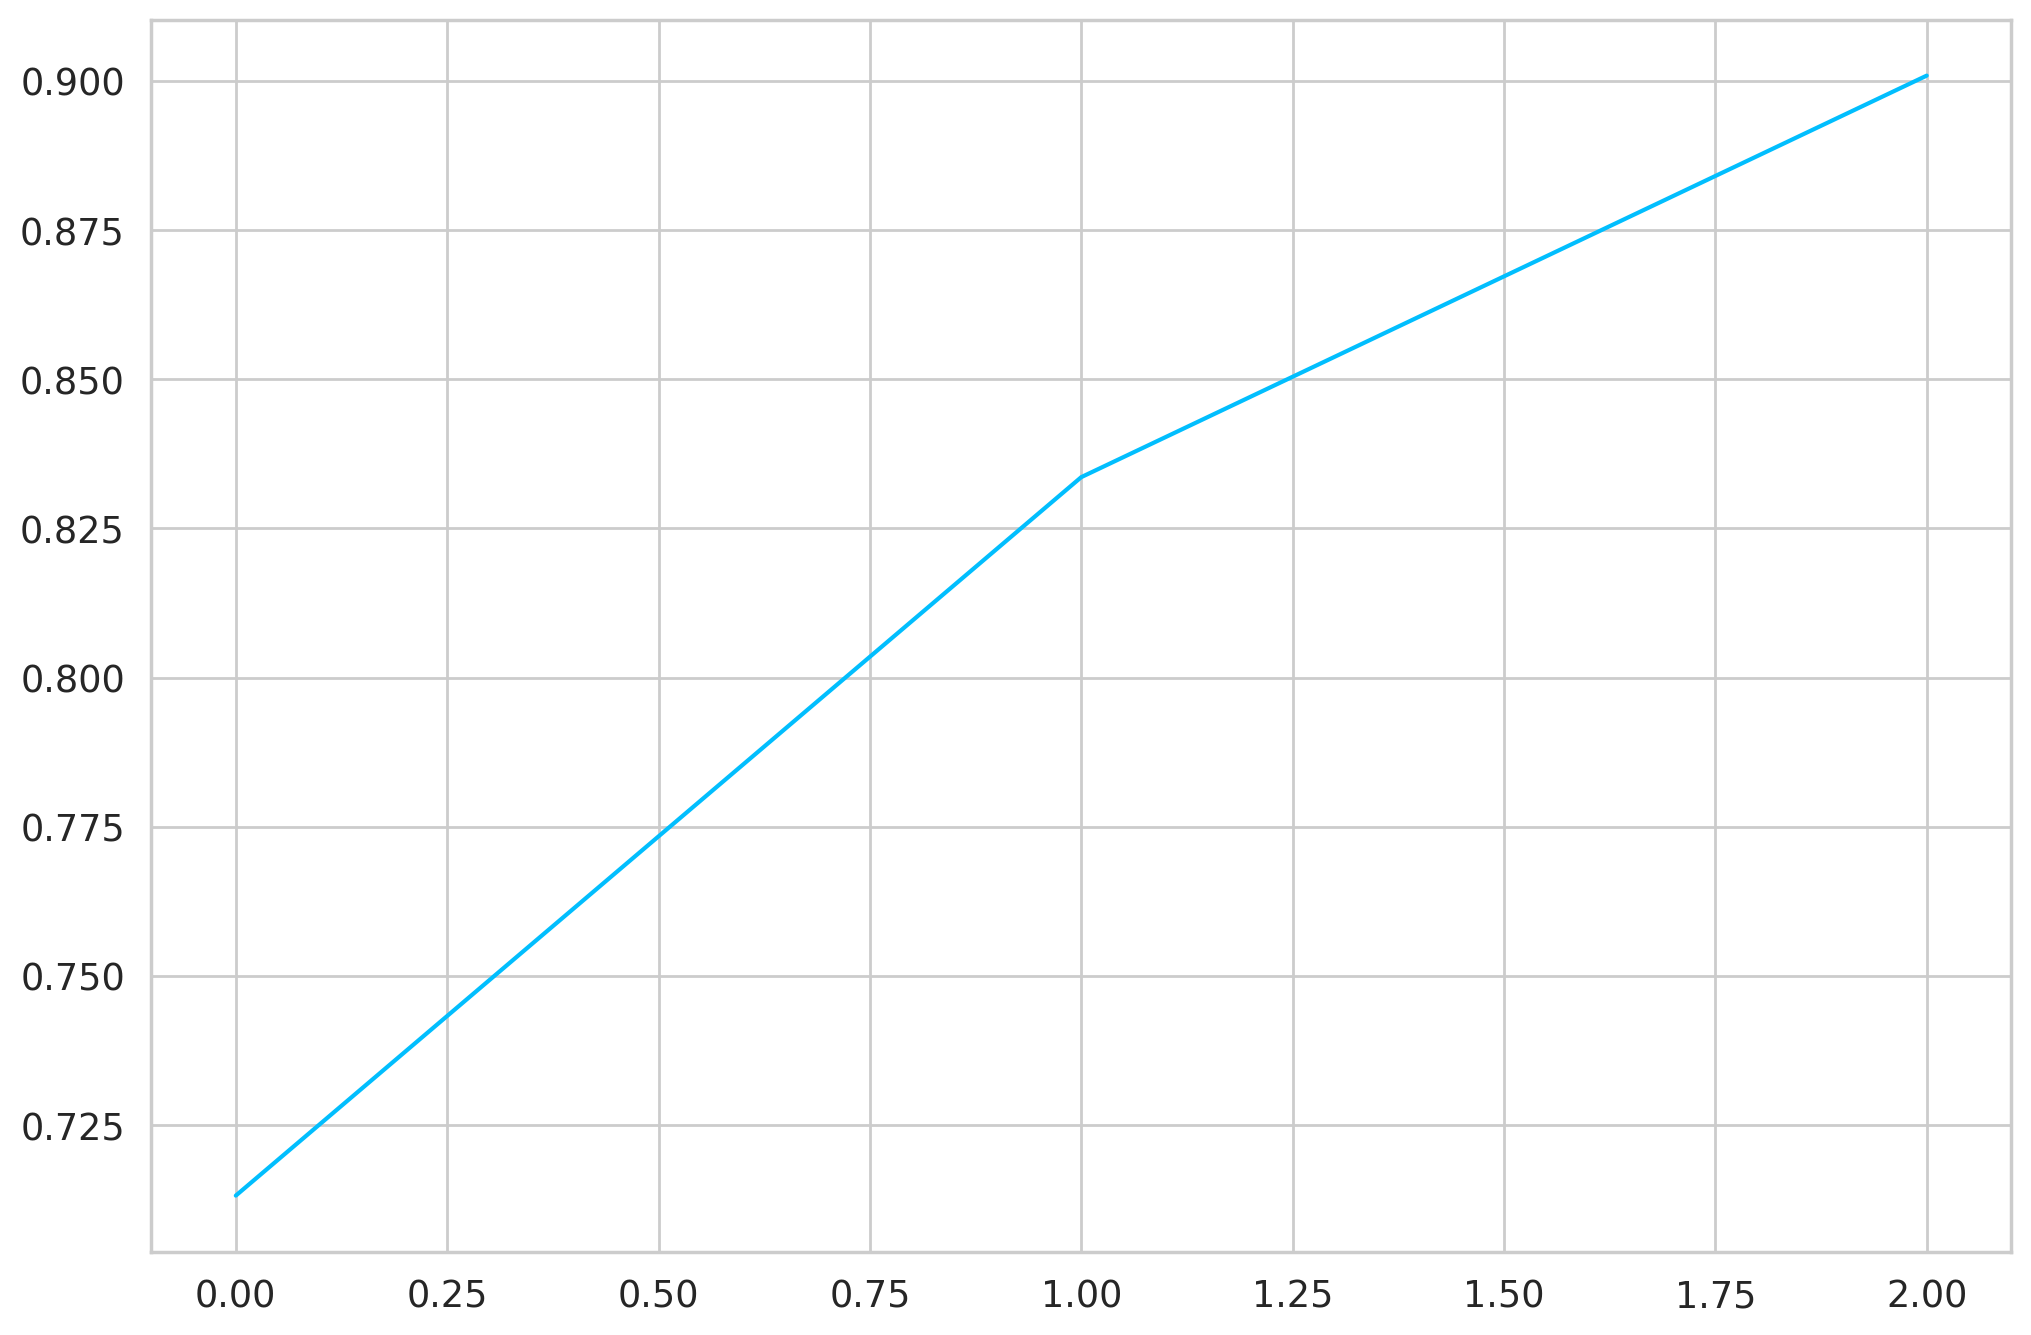

In [242]:
train_acc = [item.cpu().numpy() for item in history['train_acc']]
plt.plot(train_acc)

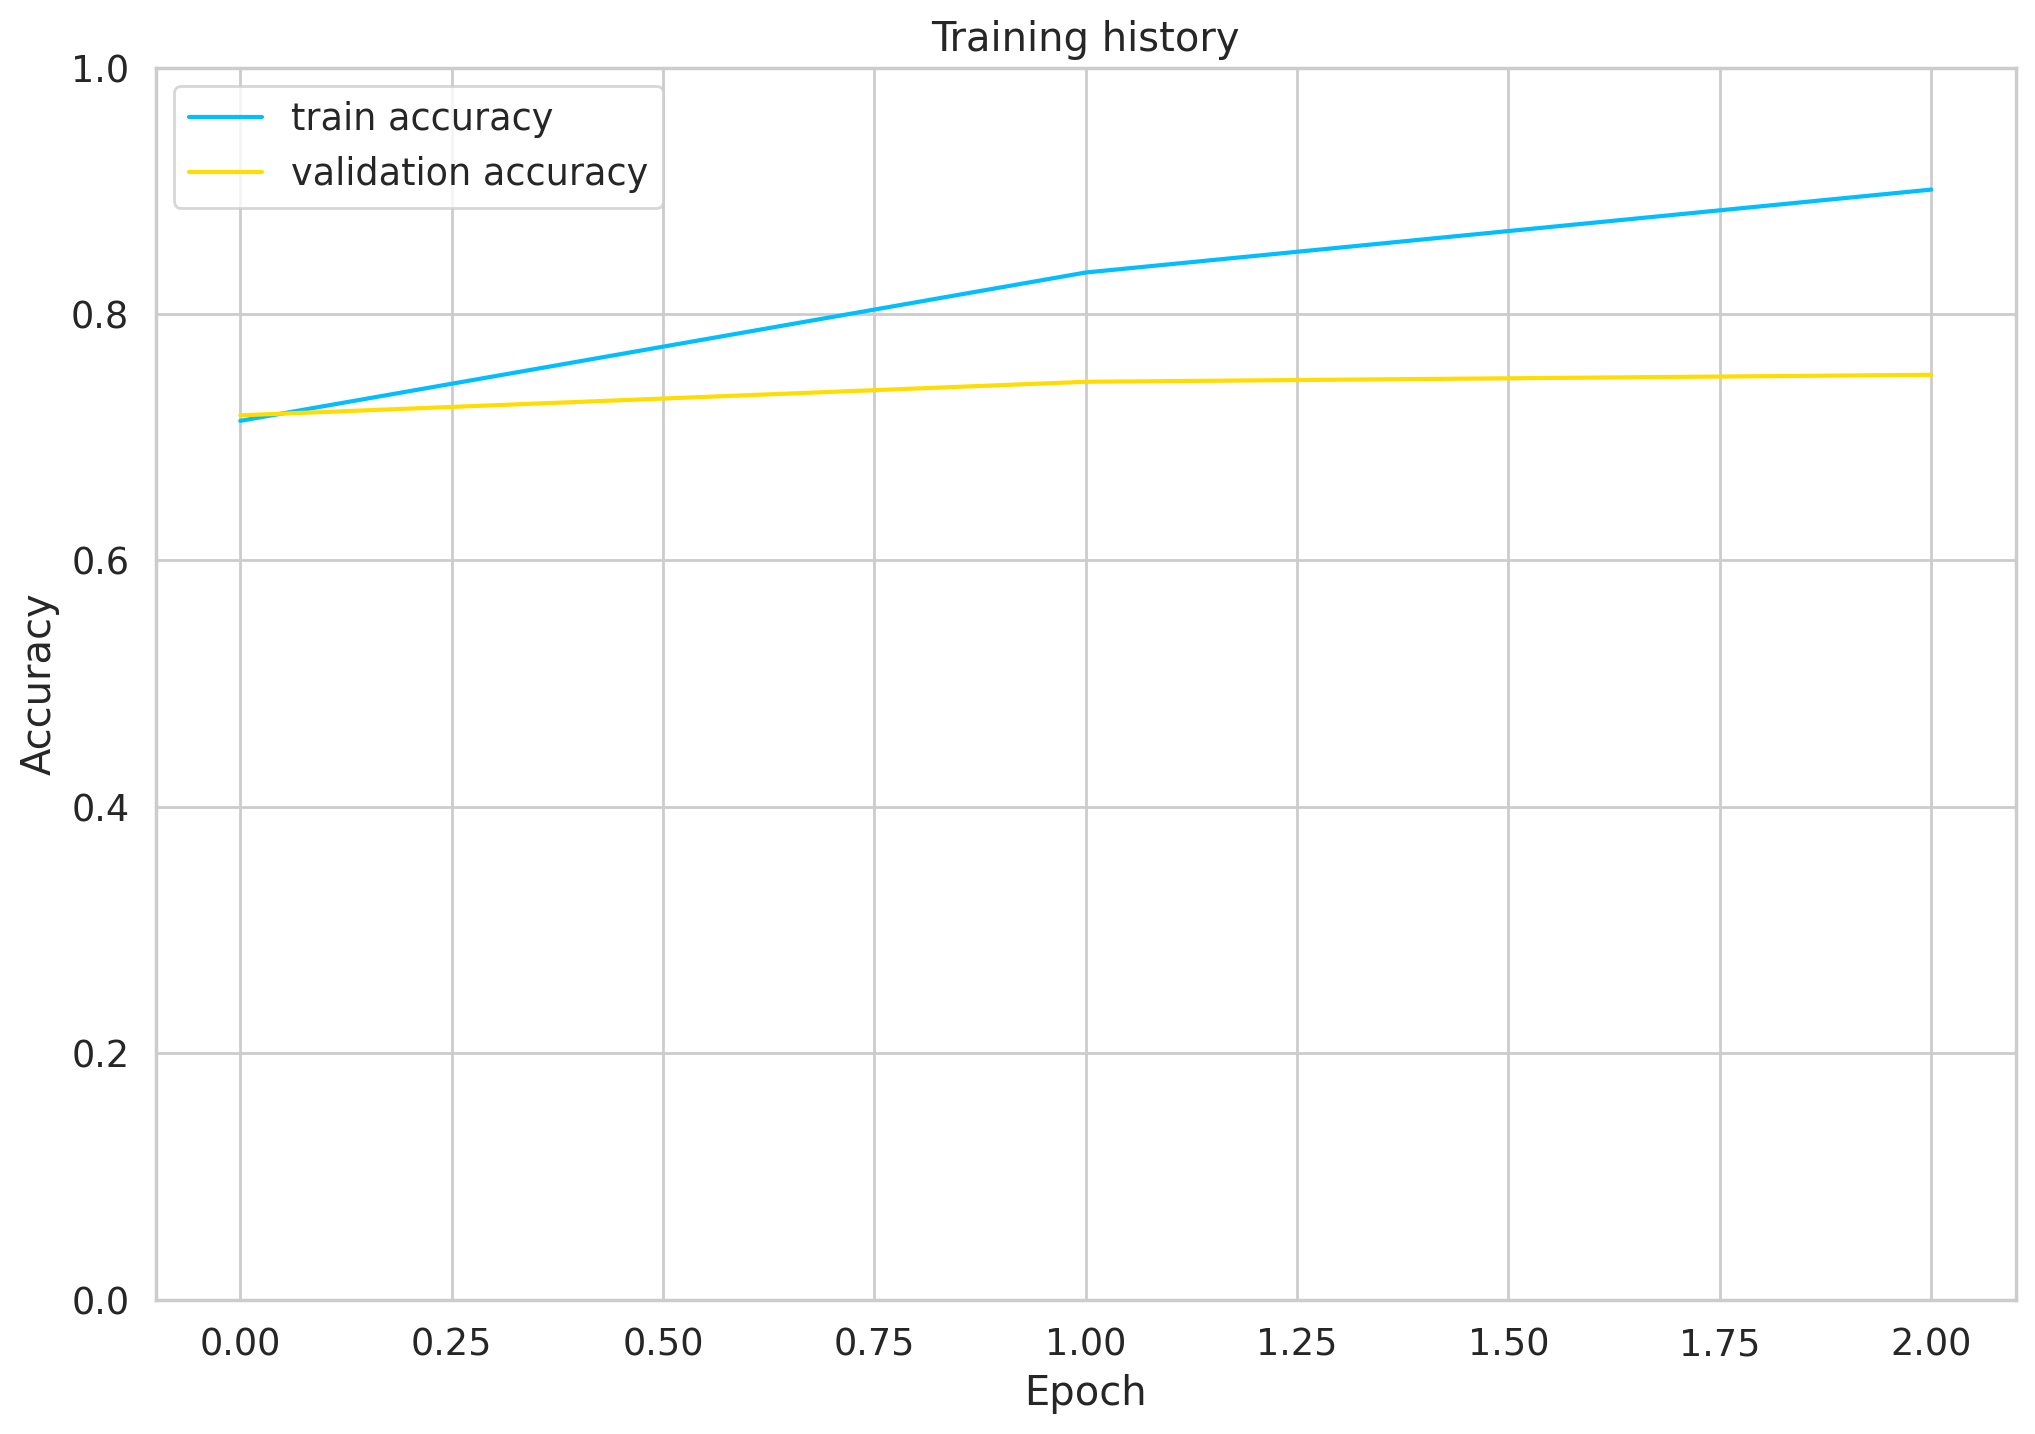

In [251]:
#PLOTTING ACCURACY
train_acc = [item.cpu().numpy() for item in history['train_acc']]
val_acc = [item.cpu().numpy() for item in history['val_acc']]
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

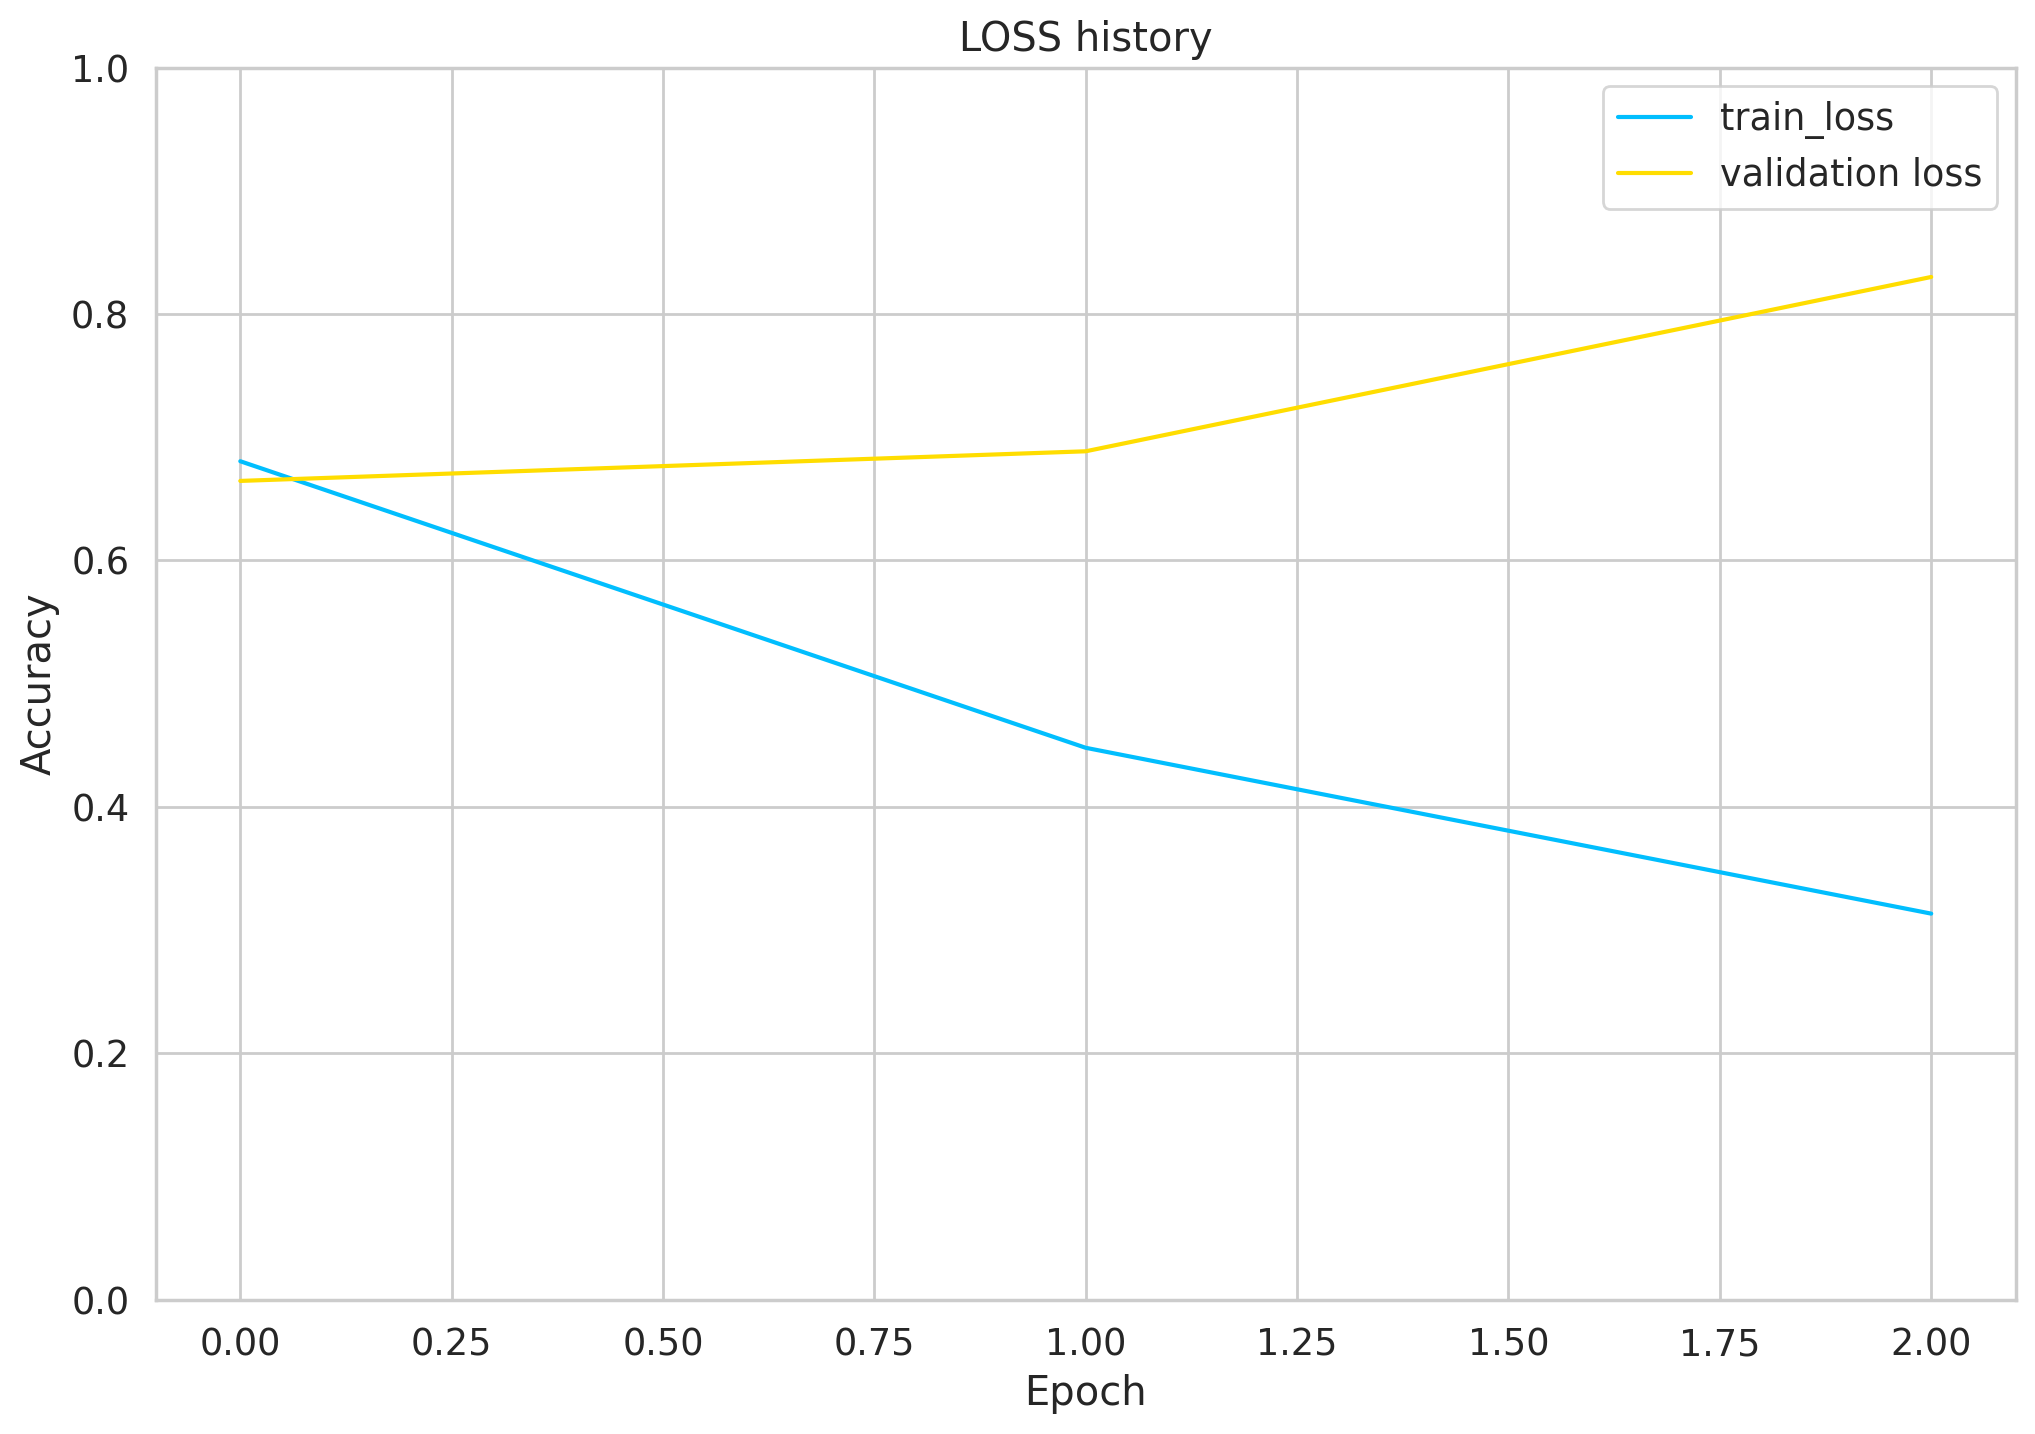

In [255]:
#PLOTTING LOSS
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('LOSS history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

CHECKING ACCURACY FOR OUR TEST DATASETS

In [272]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(f"ACCURACY FOR TEST IS: {test_acc.item()}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

ACCURACY FOR TEST IS: 0.8027210884353742


PREPARING TO SUBJECT FOR CLASSIFICATION REPORT AND CONFUSION MATRIX

In [258]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

# This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):


y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

CLASSIFICATION REPORT

In [259]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.85      0.79      0.82       321
     neutral       0.70      0.76      0.73       275
    positive       0.86      0.86      0.86       286

    accuracy                           0.80       882
   macro avg       0.80      0.80      0.80       882
weighted avg       0.81      0.80      0.80       882



CONFUSION MATRIX

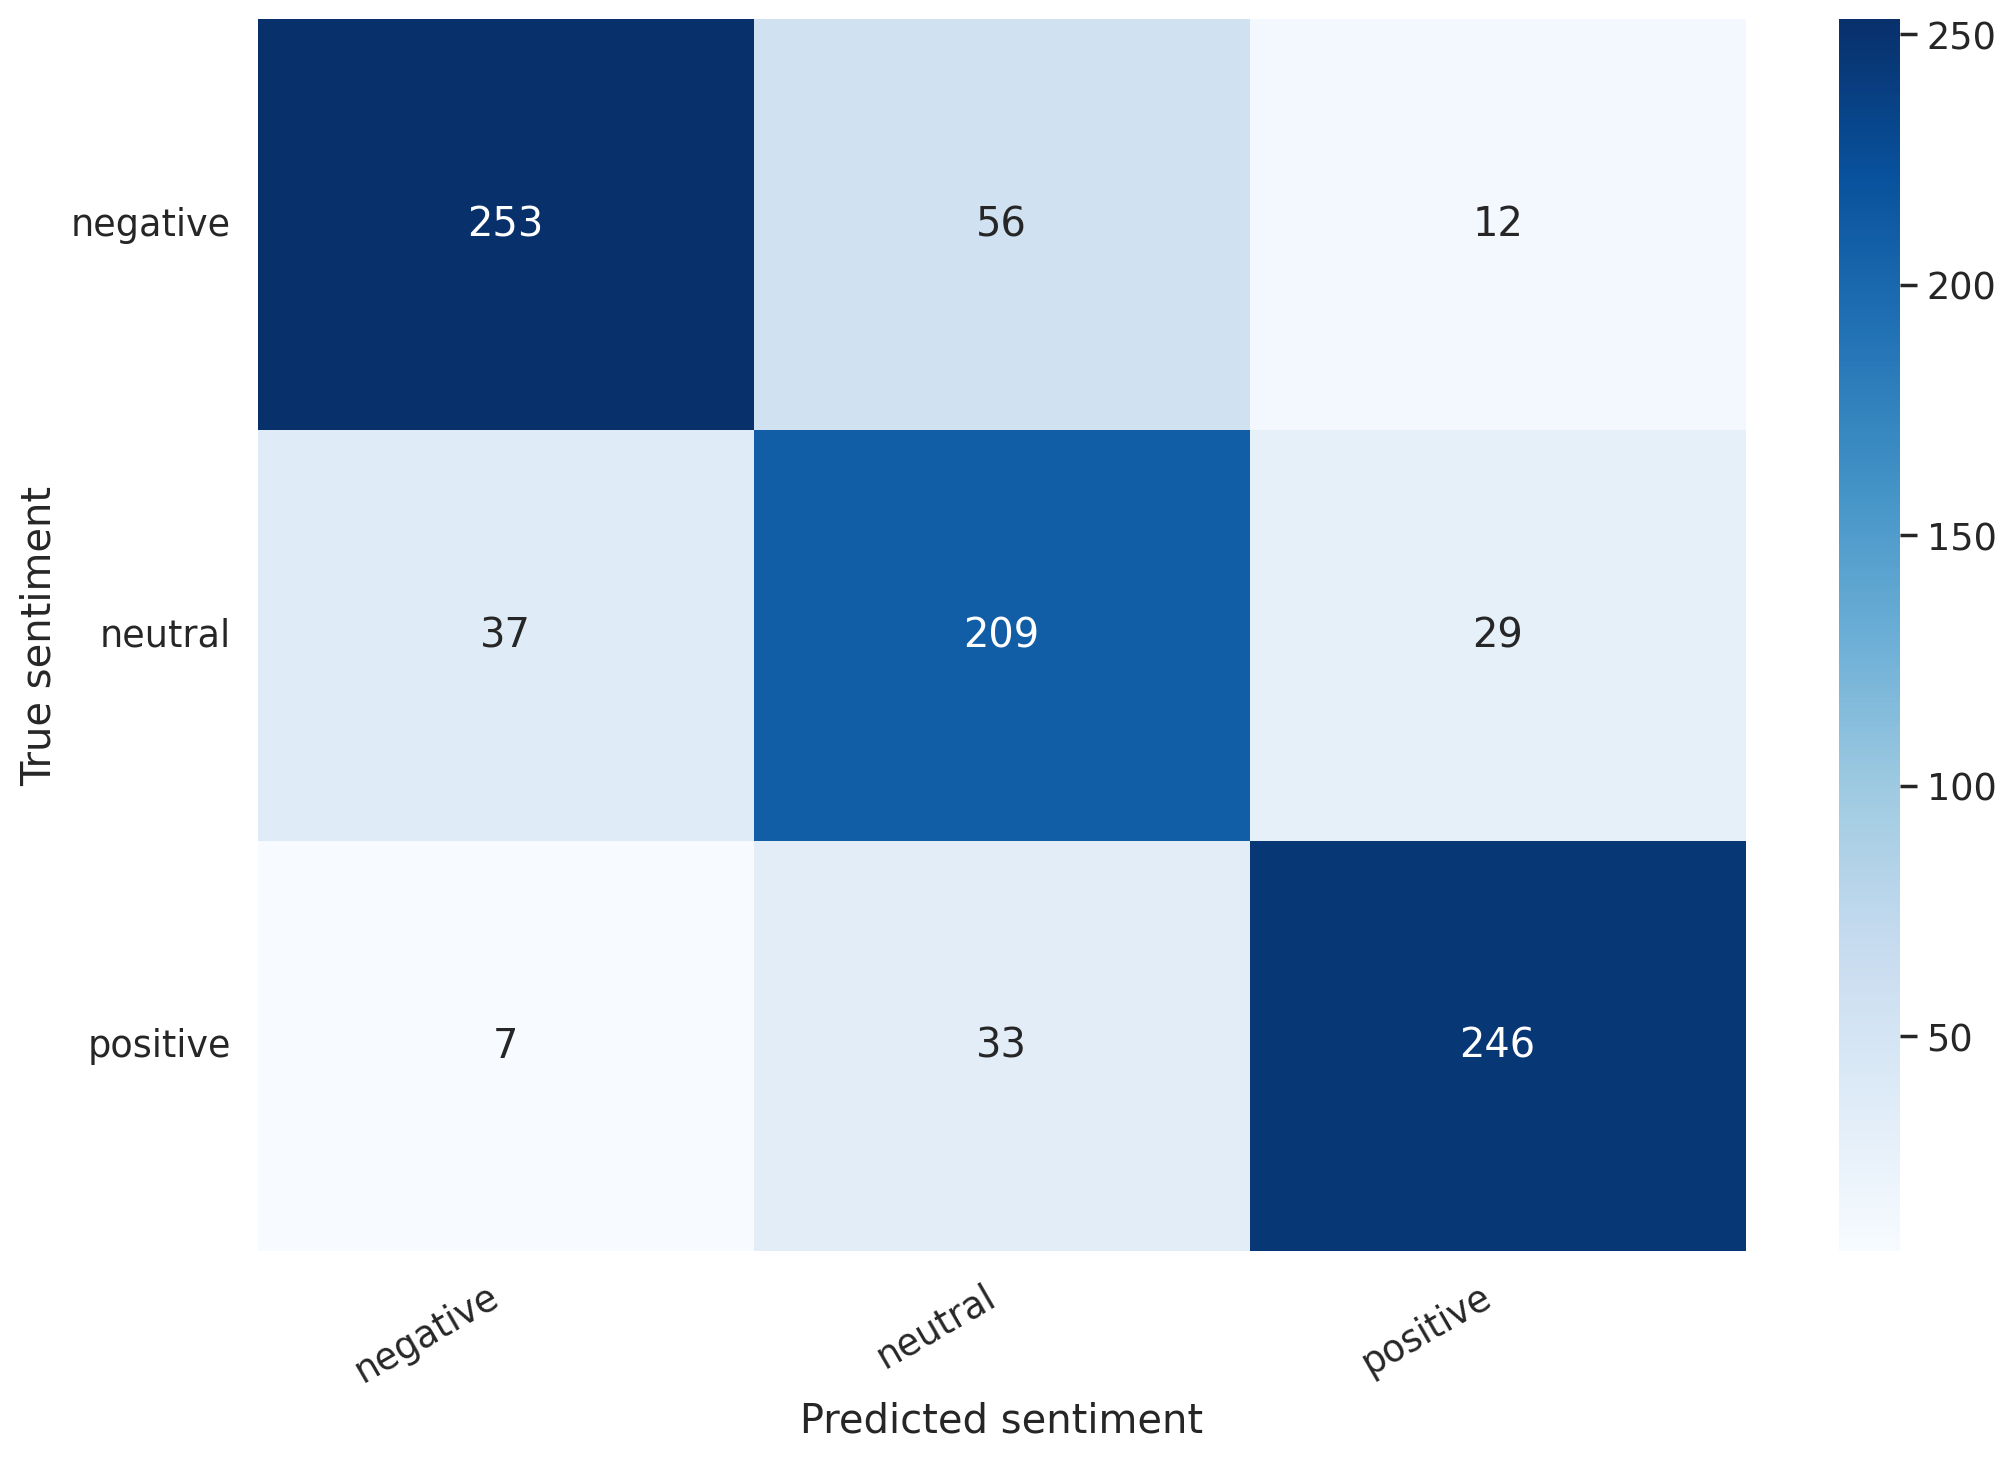

In [260]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

#NOW USING CUSTOM TEXT TO TEST OUR MODEL

In [267]:
review_text = "This app is ok types "


In [268]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


In [269]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: This app is ok types 
Sentiment  : neutral
